In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import namedtuple
import numpy as np
from scipy import optimize


Leaf = namedtuple('Leaf', ('value', 'x', 'y'))#value это число или класс размерности у
#x и y это все, что доехало до данного листа. алгу не нужны
Node = namedtuple('Node', ('feature', 'value', 'impurity', 'left', 'right',))#left and right are children 
#feat and val is i and vi from lectue. imp unused. сплиты должны уменьшать метрику
class BaseDecisionTree:
    def __init__(self, x, y, max_depth=np.inf):#глубина чтобы обрезать дерево
        self.x = np.atleast_2d(x)# х и у одинаковой длины
        self.y = np.atleast_1d(y)
        self.max_depth = max_depth
        
        self.features = x.shape[1]
        
        self.root = self.build_tree(self.x, self.y)
    
    # Will fail in case of depth ~ 1000 because of limit of recursion calls
    def build_tree(self, x, y, depth=1):
        if depth > self.max_depth or self.criteria(y) < 1e-6:#crit is h in lecture
            return Leaf(self.leaf_value(y), x, y)
        
        feature, value, impurity = self.find_best_split(x, y)
        
        left_xy, right_xy = self.partition(x, y, feature, value)
        left = self.build_tree(*left_xy, depth=depth + 1)
        right = self.build_tree(*right_xy, depth=depth + 1)
        
        return Node(feature, value, impurity, left, right)
    
    def leaf_value(self, y):
        raise NotImplementedError
    
    def partition(self, x, y, feature, value):
        r = x[:, feature] >= value
        l = np.logical_not(r)
        return (x[l], y[l]), (x[r], y[r])
    
    def _impurity_partition(self, value, feature, x, y):
        (_, left), (_, right) = self.partition(x, y, feature, value)
        return self.impurity(left, right)
    
    def find_best_split(self, x, y):
        best_feature, best_value, best_impurity = 0, x[0,0], np.inf
        for feature in range(self.features):
            if x.shape[0] > 2:
                x_interval = np.sort(x[:,feature])
                res = optimize.minimize_scalar(
                    self._impurity_partition, 
                    args=(feature, x, y),
                    bounds=(x_interval[1], x_interval[-1]),
                    method='Bounded',
                )
                assert res.success
                value = res.x
                impurity = res.fun
            else:
                value = np.max(x[:,feature])
                impurity = self._impurity_partition(value, feature, x, y)
            if impurity < best_impurity:
                best_feature, best_value, best_impurity = feature, value, impurity
        return best_feature, best_value, best_impurity
    
    # Can be optimized for given .criteria()
    def impurity(self, left, right):
        h_l = self.criteria(left)
        h_r = self.criteria(right)
        return (left.size * h_l + right.size * h_r) / (left.size + right.size)
    
    def criteria(self, y):
        raise NotImplementedError
        
    def predict(self, x):
        x = np.atleast_2d(x)
        y = np.empty(x.shape[0], dtype=self.y.dtype)
        for i, row in enumerate(x):
            node = self.root
            while not isinstance(node, Leaf):
                if row[node.feature] >= node.value:
                    node = node.right
                else:
                    node = node.left
            y[i] = node.value
        return y

In [2]:
class DecisionTreeClassifier(BaseDecisionTree):
    def leaf_value(self, y):
        return np.round(np.mean(y))
    def criteria(self, y):
        p = np.mean(y)
        return p * (1 - p)

In [3]:
COLORS = np.array([[1.,0.,0.], [0.,0.,1.]])
def do(f):
    n= 100
    x = np.random.normal(0,1, size=(n,2))
    y = np.asarray(f(x), dtype=float)
    dtc = DecisionTreeClassifier(x,y)
    y_pred = np.asarray(dtc.predict(x), dtype=int)
    assert np.array_equal(y, y_pred)
    plt.figure()
    plt.scatter(*x.T, color=COLORS[y_pred], s=15)

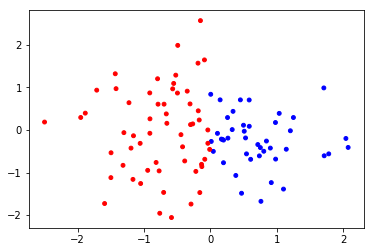

In [4]:
do(lambda x: x[:, 0] > 0)